In [9]:
from sunpy.net import Fido, attrs as a
from astropy import units as u
import matplotlib.pyplot as plt
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
import pandas as pd
# import glob
# from stixpy.net import client
# import sunpy_soar

In [10]:
flare_time_range = ['2013-11-09 06:38:00', '2013-11-09 06:38:11']

# Band  FWHM    Primary role,                                           Typical Temperature
# (Å)   (Δλ, Å) ion(s)          Region of the Sun's atmosphere	        (as log T[K])
# 
# 335   16.5	Fe xvi	        Active region corona	                6.4
# 304   12.7	He ii	        Chromosphere, transition region	        4.7
# 211	7.0	    Fe xiv	        Active region corona	                6.3
# 193	6.0	    Fe xii, xxiv	Corona and hot flare plasma	            6.1, 7.3
# 171	4.7	    Fe ix	        Quiet corona, upper transition region   5.8
# 131	4.4	    Fe xx, xxiii	Flaring regions	                        7.0, 7.2
# 94	0.9	    Fe xviii	    Flaring regions	                        6.8

# wavelength = 335  # Active region corona                      - okay, footpoints & some loop?
# wavelength = 304  # Chromosphere, transition region           - interesting, footpoints?
# wavelength = 211  # Active region corona                      - nice, but not much flare
# wavelength = 193  # Corona and hot flare plasma               - nice, but not much flare
# wavelength = 171  # Quiet corona, upper transition region     - good
wavelength = 131  # Flaring regions                           - good
# wavelength = 94   # Flaring regions                           - trash

result = Fido.search(
    a.Time(flare_time_range[0], flare_time_range[-1]),
    a.Instrument("AIA"), 
    a.Wavelength(wavelength * u.angstrom),
    a.Sample(1/60 * u.min)
)

aia_fits_path = Fido.fetch(result, path = 'aia_data')

Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.27s/file]


In [24]:
def fov_vertices(xcen, ycen, fovx, fovy):
    top_right = (xcen + (fovx/2), ycen + (fovy/2))
    bottom_left = (xcen - (fovx/2), ycen - (fovy/2))

    return top_right, bottom_left

c:\Users\james\Documents\Coding\sff_experimentation\venv\Lib\site-packages\astropy\visualization\wcsaxes\patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)
c:\Users\james\Documents\Coding\sff_experimentation\venv\Lib\site-packages\astropy\visualization\wcsaxes\patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)
c:\Users\james\Documents\Coding\sff_experimentation\venv\Lib\site-packages\astropy\visualization\wcsaxes\patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)
c:\Users\james\Documents\Coding\sff_experimentation\venv\Lib\site-packages\astropy\visualization\wcsaxes\patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(

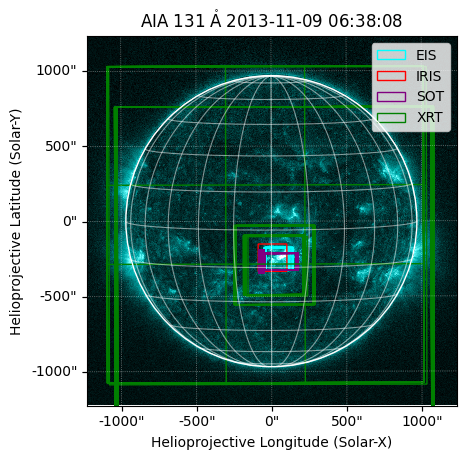

In [30]:
plot_font = {'fontname':'Times New Roman'}

aia_map = sunpy.map.Map(aia_fits_path[0])
aia_map.plot(clip_interval=(0.1, 99.99)*u.percent)

normalise = False

if normalise:
    norm = ImageNormalize(vmin=0, vmax=200, stretch=SqrtStretch())
    aia_map.plot(norm=norm)
    normalised = "_normalised"
else:
    normalised = ""

aia_map.draw_limb()
aia_map.draw_grid()

sub_disk_instruments = ['eis', 'iris', 'sot', 'xrt']

instrument_colour_legend = {
    'eis': 'cyan',
    'iris': 'red',
    'sot': 'purple',
    'xrt': 'green'
}

for instr in sub_disk_instruments:
    pointing_df = pd.read_csv(f"aia_data/{instr}_pointing_2013.csv")
    first = True

    for _, row in pointing_df.iterrows():

        top_right_coord, bottom_left_coord = fov_vertices(
            row['XCEN'], row['YCEN'], row['FOVX'], row['FOVY']
        )

        # Drawing boxes
        top_right = SkyCoord(
            top_right_coord[0]*u.arcsec, 
            top_right_coord[1]*u.arcsec, 
            frame=aia_map.coordinate_frame
        )

        bottom_left = SkyCoord(
            bottom_left_coord[0]*u.arcsec,
            bottom_left_coord[1]*u.arcsec,
            frame=aia_map.coordinate_frame
        )

        if first:
            aia_map.draw_quadrangle(
                bottom_left,
                top_right=top_right,
                color=instrument_colour_legend.get(instr),
                linewidth=1,
                label=instr.upper()
            )
            first = False
        else:
            aia_map.draw_quadrangle(
                bottom_left,
                top_right=top_right,
                color=instrument_colour_legend.get(instr),
                linewidth=1
            )

plt.savefig(
    f"plots/2013_well_observed_flare_AIA_{wavelength}a{normalised}.png",
    format='png',
    bbox_inches='tight',
    dpi=300
)

plt.legend(loc='upper right')

plt.show()